In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 2
input_size = (540, 960)
target_size = (input_size[0]*4, input_size[1]*4)

In [3]:
train_img_list_label = r"F:\dataset\UHDSR4K\4K\train\HR"
train_img_list_data = r"F:\dataset\UHDSR4K\4K\train\LR_X4"

test_img_list_label = r"F:\dataset\UHDSR4K\4K\test\HR"
test_img_list_data = r"F:\dataset\UHDSR4K\4K\test\LR_X4"


img_list_label = tf.io.matching_files(f'{train_img_list_label}\*.*')
img_list_data = tf.io.matching_files(f'{train_img_list_data}\*.*')
train_ds = tf.data.Dataset.from_tensor_slices((img_list_data, img_list_label))

img_list_label = tf.io.matching_files(f'{test_img_list_label}\*.*')
img_list_data = tf.io.matching_files(f'{test_img_list_data}\*.*')
test_ds = tf.data.Dataset.from_tensor_slices((img_list_data, img_list_label))

def read_image(img,label):
    img = tf.io.read_file(img)
    img = tf.io.decode_image(img)
    img.set_shape((*input_size,3))
    label = tf.io.read_file(label)
    label = tf.io.decode_image(label)
    label.set_shape((*target_size,3))
    img = img / 255
    label = label / 255
    return img, label

train_ds_size = train_ds.cardinality()
test_ds_size = test_ds.cardinality()
valid_ds_size = train_ds_size // 5
valid_ds = train_ds.take(valid_ds_size)
train_ds = train_ds.skip(valid_ds_size)

train_ds_size = train_ds.cardinality()
test_ds_size = test_ds.cardinality()

sample = next(iter(train_ds))

train_ds = train_ds.map(read_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_ds = valid_ds.map(read_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(read_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print(train_ds_size)
print(test_ds_size)
print(valid_ds_size)

tf.Tensor(4800, shape=(), dtype=int64)
tf.Tensor(2100, shape=(), dtype=int64)
tf.Tensor(1199, shape=(), dtype=int64)


(2, 540, 960, 3)
(2, 2160, 3840, 3)


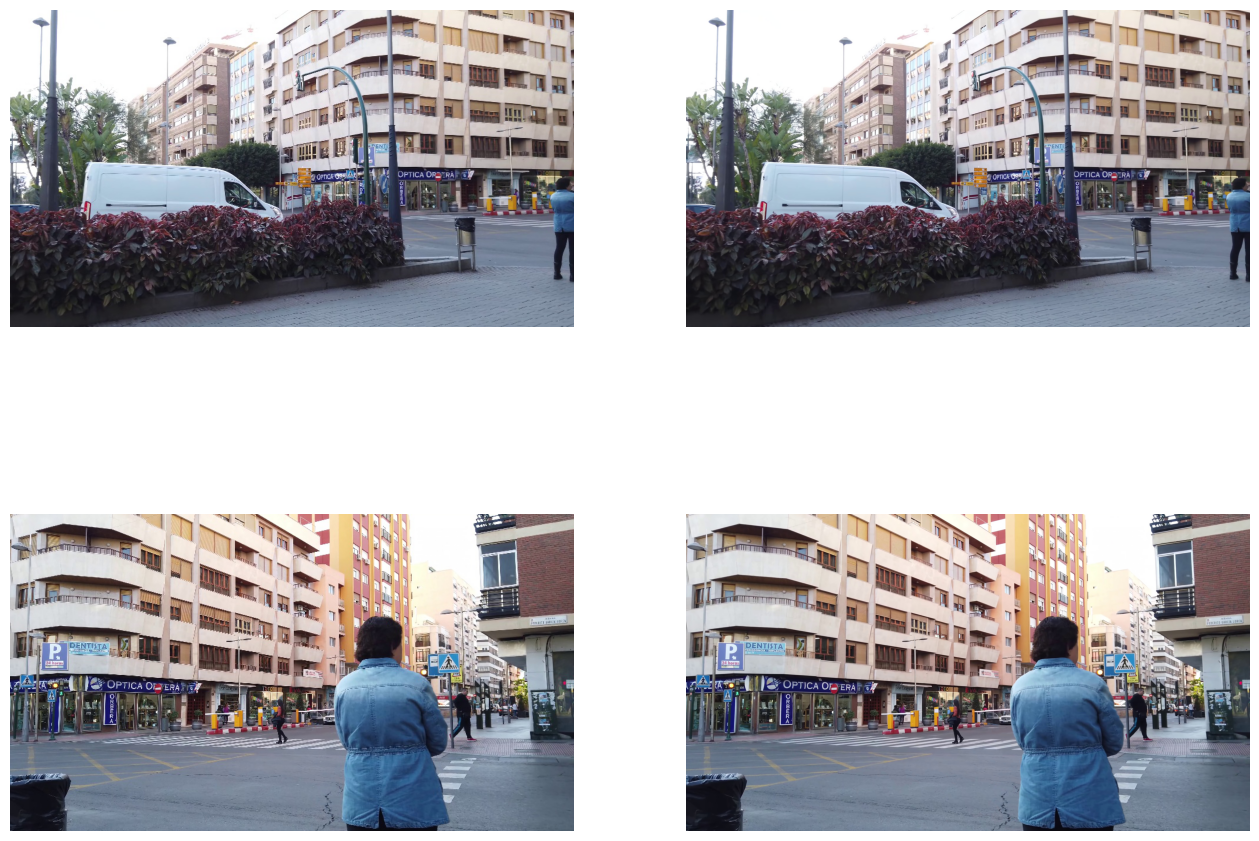

In [4]:
# visualize data
sample = next(iter(train_ds))
fig, axes = plt.subplots(2,2, figsize=(16,12))
print(sample[0].shape)
print(sample[1].shape)
for i in range(2):
    ax = axes[i, 0]
    ax.imshow(sample[0][i])
    ax.axis('off')

    ax = axes[i, 1]
    ax.imshow(sample[1][i])
    ax.axis('off')


In [39]:
# build a model


class conv_block(tf.keras.layers.Layer):
    def __init__(self, filters, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.conv = tf.keras.layers.Conv2D(filters, 3, padding='same')
        self.bn = tf.keras.layers.BatchNormalization()
        self.activate = tf.keras.layers.ReLU()
        self.maxpool = tf.keras.layers.MaxPooling2D(2, strides= 2)


    def call(self, inputs, training=False):
        x = self.conv(inputs)
        x = self.bn(x)
        x = self.activate(x)
        x = self.maxpool(x)
        return x

class deconv_block(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.conv = tf.keras.layers.Conv2DTranspose(filters, kernel_size, strides = 2, padding = 'same')
        self.bn = tf.keras.layers.BatchNormalization()
        self.activate = tf.keras.layers.ReLU()

    def call(self, inputs, training=False):
        x = self.conv(inputs)
        x = self.bn(x)
        x = self.activate(x)
        return x
        

class SRCNN(tf.keras.Model):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        kenel_sizes =[5, 5]
        self.deconv_blocks = [deconv_block(32, kenel_sizes[i]) for i in range(2)]
        self.head_layer = tf.keras.layers.Conv2D(3, 3, padding='same')
    def call(self, x, training=False):

        for i in range(2):
            x = self.deconv_blocks[i](x)

        x =  self.head_layer(x)
        return x


In [40]:
model = SRCNN()
model.build((None, *sample[0].shape[1:]))
model.summary()
output = model(sample[0])
print(output.shape)


Model: "srcnn_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 deconv_block_8 (deconv_bloc  multiple                 2560      
 k)                                                              
                                                                 
 deconv_block_9 (deconv_bloc  multiple                 51520     
 k)                                                              
                                                                 
 conv2d_5 (Conv2D)           multiple                  1731      
                                                                 
Total params: 55,811
Trainable params: 55,619
Non-trainable params: 192
_________________________________________________________________
(2, 2160, 3840, 3)


In [41]:
loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam()
checkpoints = tf.keras.callbacks.ModelCheckpoint("trained_model_{epoch:02d}_{acc:0.4f}.h5", monitor="val_acc", save_weights_only=True)
model.compile(loss = loss, optimizer = optimizer, metrics=['acc'])
model.fit(train_ds, validation_data = valid_ds, epochs=10, callbacks=[checkpoints])


Epoch 1/10


ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/srcnn_3/deconv_block_9/batch_normalization_11/FusedBatchNormGradV3' defined at (most recent call last):
    File "c:\Users\evilr\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\evilr\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\evilr\AppData\Roaming\Python\Python39\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\evilr\AppData\Local\Programs\Python\Python39\lib\site-packages\traitlets\config\application.py", line 1041, in launch_instance
      app.start()
    File "C:\Users\evilr\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\evilr\AppData\Roaming\Python\Python39\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\evilr\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\evilr\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\evilr\AppData\Local\Programs\Python\Python39\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\evilr\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\evilr\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\evilr\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\evilr\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\evilr\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "C:\Users\evilr\AppData\Roaming\Python\Python39\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\evilr\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 2885, in run_cell
      result = self._run_cell(
    File "C:\Users\evilr\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 2940, in _run_cell
      return runner(coro)
    File "C:\Users\evilr\AppData\Roaming\Python\Python39\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\evilr\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3139, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\evilr\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3318, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\evilr\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3378, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\evilr\AppData\Local\Temp\ipykernel_22244\116978946.py", line 5, in <module>
      model.fit(train_ds, validation_data = valid_ds, epochs=10, callbacks=[checkpoints])
    File "c:\Users\evilr\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\evilr\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\evilr\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\evilr\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\evilr\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\evilr\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 997, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "c:\Users\evilr\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 576, in minimize
      grads_and_vars = self._compute_gradients(
    File "c:\Users\evilr\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 634, in _compute_gradients
      grads_and_vars = self._get_gradients(
    File "c:\Users\evilr\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 510, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/srcnn_3/deconv_block_9/batch_normalization_11/FusedBatchNormGradV3'
OOM when allocating tensor with shape[2,64,2160,3840] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/srcnn_3/deconv_block_9/batch_normalization_11/FusedBatchNormGradV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_130461]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


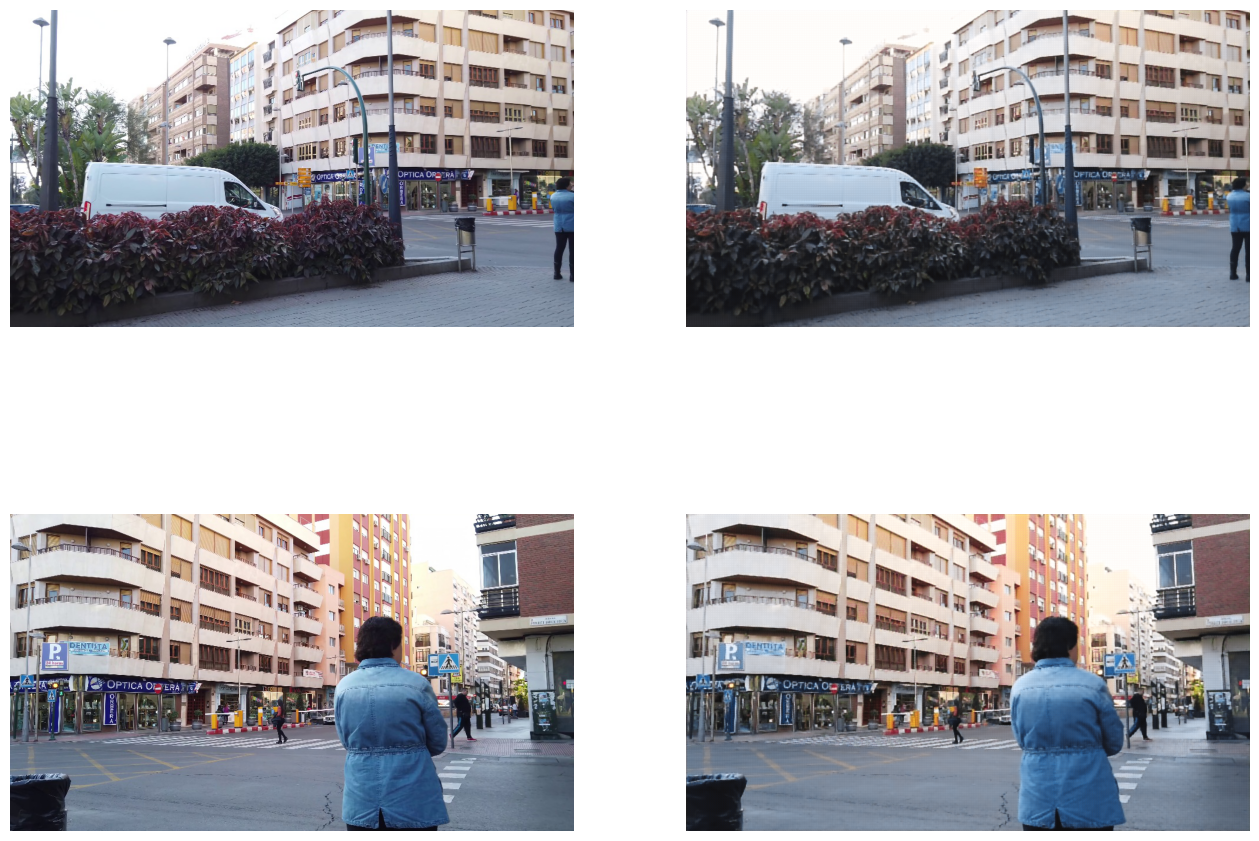

In [32]:
import cv2
import numpy as np 
output = model(sample[0])

# visualize data
fig, axes = plt.subplots(2,2, figsize=(16,12))
img = tf.reverse(sample[0][0], axis=[-1])
img = img * 255
img = img.numpy()

img.astype(np.uint8)
cv2.imwrite("original.png", img)

img = tf.reverse(output[0], axis=[-1])
img = img * 255
img = img.numpy()

img.astype(np.uint8)
cv2.imwrite("output.png", img)
for i in range(2):
    ax = axes[i, 0]
    ax.imshow(sample[0][i])
    
    ax.axis('off')

    ax = axes[i, 1]
    ax.imshow(output[i])
    ax.axis('off')
